# Package

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Importation

In [1]:
# Lire le fichier brut
with open("lbl-tcp-3.tcp", "r", encoding="latin-1") as f:
    lignes = f.readlines()

# Afficher quelques lignes pour voir la structure
for i, ligne in enumerate(lignes[:20]):  # juste les 20 premières
    print(i, ligne.strip())

0 759103800.008185 1 2 23 2436 1
1 0.010445 2 1 2436 23 2
2 0.023775 1 2 23 2436 2
3 0.026558 2 1 2436 23 1
4 0.029002 3 4 3930 119 42
5 0.032439 4 3 119 3930 15
6 0.049618 1 2 23 2436 1
7 0.052431 5 2 14037 23 2
8 0.056457 2 5 23 14037 2
9 0.057815 6 7 23 1502 414
10 0.072126 8 9 1023 513 0
11 0.098415 3 4 3930 119 55
12 0.104465 4 3 119 3930 15
13 0.122345 10 11 6000 2290 0
14 0.124490 7 6 1502 23 0
15 0.125228 2 1 2436 23 1
16 0.138935 1 2 23 2436 1
17 0.139950 12 13 1208 6000 64
18 0.140930 2 1 2436 23 1
19 0.146912 13 12 6000 1208 32


In [42]:
path = "lbl-tcp-3.tcp"
colnames = ["ts", "src_id", "dst_id", "src_port", "dst_port", "val"]
df = pd.read_csv(
    path, sep=r"\s+", header=None, names=colnames, engine="python",
    dtype={"ts": float, "src_id": np.int64, "dst_id": np.int64,
           "src_port": np.int64, "dst_port": np.int64, "val": np.int64}
)

In [48]:
# ---------- Fenêtrage 10 s ----------
t0 = df['ts'].min()
# fenêtres [0,10), [10,20), ...
df['Interval'] = np.floor((df['ts'] - t0 - 1e-9) / 10).astype(int)
df = df[df['Interval'].between(0, 719)]

# Nombre d'événements par fenêtre (720 pas)
ts_series = (
    df.groupby('Interval').size()
      .reindex(range(720), fill_value=0)
)

In [45]:
# ---------- Index temporel (DatetimeIndex régulier 10 s) ----------
# On ancre les deltas sur la vraie horloge:
origin = pd.to_datetime(t0, unit='s').floor('10S')  # ancre alignée sur 10 s
dt_index = pd.date_range(start=origin, periods=len(ts_series), freq='10S')
y = pd.Series(ts_series.values, index=dt_index, name='count')  # DatetimeIndex + freq=10S

C:\Users\Mita\AppData\Local\Temp\ipykernel_8952\1349177612.py:3: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  origin = pd.to_datetime(t0, unit='s').floor('10S')  # ancre alignée sur 10 s
C:\Users\Mita\AppData\Local\Temp\ipykernel_8952\1349177612.py:4: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dt_index = pd.date_range(start=origin, periods=len(ts_series), freq='10S')


# Graphique du Time Series

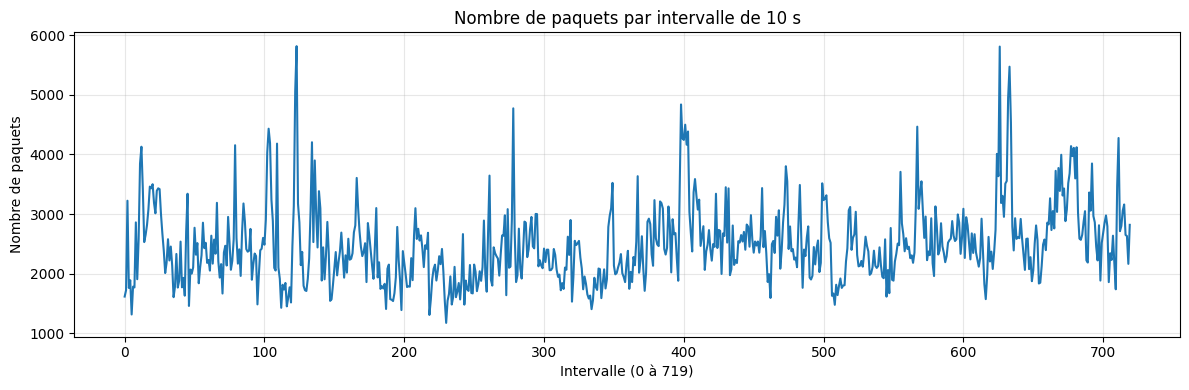

In [46]:
plt.figure(figsize=(12,4))
ts_series.plot()
plt.title("Nombre de paquets par intervalle de 10 s")
plt.xlabel("Intervalle (0 à 719)")
plt.ylabel("Nombre de paquets")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Le traffic n'augmente pas dans le temps et on observe pas une certaine saisonnalité. Intuitivement, il est stationnaire. Par contre, on s'apercôit une grande volatilité.

# Stationnarité

In [47]:
result = adfuller(ts_series)

print("Statistique ADF:", result[0])
print("p-value:", result[1])
print("Valeurs critiques:", result[4])
if result[1] < 0.05:
    print("✅ On rejette H0 : la série est stationnaire.")
else:
    print("❌ On ne rejette pas H0 : la série est non-stationnaire.")

Statistique ADF: -8.273264859803446
p-value: 4.730303272479693e-13
Valeurs critiques: {'1%': np.float64(-3.439516060164992), '5%': np.float64(-2.8655850998755263), '10%': np.float64(-2.5689240826597173)}
✅ On rejette H0 : la série est stationnaire.


# Analyse de l'autocorrélation

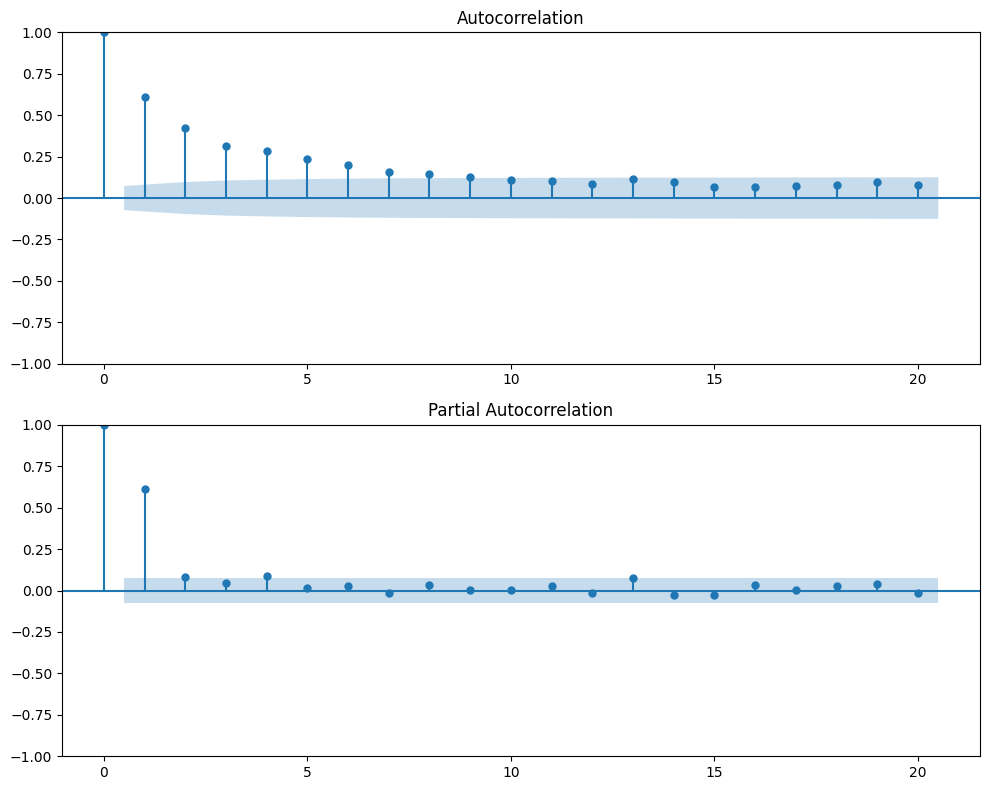

In [49]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 8))
plot_acf(ts_series, ax=ax[0], lags=20, alpha=0.05)
plot_pacf(ts_series, ax=ax[1], lags=20, alpha=0.05)

plt.tight_layout()
plt.show()

Ces graphiques montrent la corrélation de la série temporelle avec elle-même avec un retards maximal de 20. Lorsque les valeurs sont proches de 0, celà veut dire que les observations consécutives sont non corrélées. Par contre, lorsqu'elles sont proches de 1 ou -1, l'autocorrélation est présente.  

L'ACF et le PACF retournent à chacun des intervalles de confiance. La corrélation est significative lorsqu'elle déborde de cette intervalle. 

Pour le PACF, le retards égal à 1 est très significatifs et le reste est relativement faible. Une petite élevation se situe au 13è lags. L'autocorrélation s'accumule jusqu'à la 7è lags comme le montre le graphique de l'autocorrélation. 

Ces résultats justifient l'utilisation des modèles auto-régressifs. Pour AR(p), p devrait être au plus égal à 7. Nous allons donc chercher maintenant la valeur optimale de p.  

# Choix de paramètre du modèle AR(p)

## Critère AIC

In [50]:
# ============================================
# Étape 1 — Préparation des données et des paramètres
# ============================================
y = pd.Series(ts_series, dtype = float).dropna()
n = len(y)
h = int(0.2 * n)
y_train, y_test = y[:h], y[h:]
idx_train, idx_test = y_train.index, y_test.index
pmax = 7
len(y_train) , len(y_test)

(144, 576)

In [51]:
# Etape 2 : AIC
for p in range (1, pmax + 1):
    mod = ARIMA (endog = y_train, order = (p, 0, 0))
    res = mod.fit()
    print(f"aic ({p}) : {res.aic}")

aic (1) : 2269.440706008174
aic (2) : 2271.429800663103
aic (3) : 2272.9923630772582
aic (4) : 2274.712002850604
aic (5) : 2276.3468791954992
aic (6) : 2277.4720274014608
aic (7) : 2276.538982813931


Plus la valeur de p augmente, plus AIC augmente en principe. Mais de p = 6 à 7, il commence à diminuer. Ce qui laisse présager que l'on peut trouver un meilleur p à 13? Essayons

In [54]:
# Etape 2 : AIC
pmax = 13
for p in range (1, pmax + 1):
    mod = ARIMA (endog = y_train, order = (p, 0, 0))
    res = mod.fit()
    print(f"aic ({p}) : {res.aic}")

aic (1) : 2269.440706008174
aic (2) : 2271.429800663103
aic (3) : 2272.9923630772582
aic (4) : 2274.712002850604
aic (5) : 2276.3468791954992
aic (6) : 2277.4720274014608
aic (7) : 2276.538982813931
aic (8) : 2277.9549295177912
aic (9) : 2279.464873394264
aic (10) : 2281.495873200057
aic (11) : 2282.9431516714817
aic (12) : 2284.968389861757
aic (13) : 2286.038710773854


Pour AIC, AR(p) = AR(1). Essayons avec BIC.

In [55]:
# BIC
for p in range (1, pmax + 1):
    mod = ARIMA (endog = y_train, order = (p, 0, 0))
    res = mod.fit()
    print(f"aic ({p}) : {res.bic}")

aic (1) : 2278.350145906902
aic (2) : 2283.309053861407
aic (3) : 2287.841429575138
aic (4) : 2292.53088264806
aic (5) : 2297.1355722925314
aic (6) : 2301.230533798069
aic (7) : 2303.267302510115
aic (8) : 2307.653062513551
aic (9) : 2312.1328196896
aic (10) : 2317.133632794969
aic (11) : 2321.5507245659696
aic (12) : 2326.5457760558206
aic (13) : 2330.585910267494


Pareil, BIC confirme qu'il faut avoir AR(1). Voyons voir maintenant le cas de Backtesting

In [75]:
# Etablir une fonction de Backtesting pour le choix de p dans AR(p)
def ts_backtesting (s, pmax, nchunks) :
    s = pd.Series(s).dropna()
    n = len(s)
    cuts = np.linspace(0, n , nchunks + 1, dtype = int) # Puisque iloc en bas exige un float
    results = []

    for k in range ( nchunks - 1 ) : 
        for p in range (1 , pmax + 1) : 
            train = s.iloc[:cuts[k+1]]
            validation = s.iloc[cuts[k+1]:cuts[k+2]]

            try : 
                mod = ARIMA(train, order = (p,0,0))
                res = mod.fit()

                forecast = pd.Series(res.forecast(steps = len(validation)), index=validation.index)
                rmse_fold = np.sqrt(((validation - forecast) ** 2).mean())
                
                results.append((p, rmse_fold))
        
            except Exception : 
                rmse.append(np.nan)

    df_results = pd.DataFrame(results, columns=["p", "rmse"])
    return df_results.groupby("p")["rmse"].mean()

In [76]:
# Appeler la fonction de Backtesting
ts_backtesting(ts_series, pmax=pmax, nchunks = 5)

p
1     634.227435
2     634.126009
3     634.438345
4     634.465963
5     634.295649
6     634.411143
7     634.235775
8     634.281440
9     634.170347
10    634.287050
11    634.189823
12    634.098379
13    634.007343
Name: rmse, dtype: float64

Ici, c'est p = 13 qui donne le RMSE le plus bas. 

# Tester les modèles et choisir